In [1]:
import json

In [14]:
data = json.load(open('to-grade/all-singles.tmp.json'))
dataset = json.load(open('conala-dataset.json'))

In [27]:
def get_key(k):
    if k.endswith('-rerank'):
        return k.replace('-rerank', '-bleu-rerank')
    return k + '-bleu'

def get_val(d2, k):
    k = k.replace('grade-', '')
    if k == 'snippet':
        return 1.
    return d2[get_key(k.replace('grade-', ''))]

In [45]:
pairs = []
for d1, d2 in zip(data, dataset):
    assert d1['snippet'] == d2['snippet']
    or_intent = d2['rewritten_intent'] if d2['rewritten_intent'] is not None else d2['intent']
    assert d1['intent'] == or_intent
    for k in d1:
        if k.startswith('grade-'):
            pairs.append((
                d1[k], 
                get_val(d2, k)
            ))

In [46]:
pairs[:5]

[(1, 0.3554), (0, 0.0813), (2, 0.6274), (4, 1.0), (3, 1.0)]

In [47]:
import matplotlib.pyplot as plt

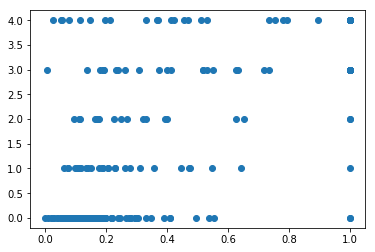

In [48]:
plt.plot([p[1] for p in pairs], [p[0] for p in pairs], 'o')